In [15]:
from utils import CNFFormula
from models.rbm import clauseRBM
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# with open("wcnfdata/ram_k3_n18.ra0.wcnf", 'r') as f:
#     cnf_str = f.read()

# with open("wcnfdata/brock200_3.clq.wcnf", 'r') as f:
#     cnf_str = f.read()

with open("wcnfdata/ram_k3_n11.ra0.wcnf", 'r') as f:
    cnf_str = f.read()

formula = CNFFormula(cnf_str)
formula.padding()
rbm = clauseRBM(formula.max_clause_length, device=device)

new s_max found 483 at step 1
new s_max found 485 at step 2
new s_max found 486 at step 4
new s_max found 487 at step 34082
tensor([1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1.,
        0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
        0.], device='cuda:0')


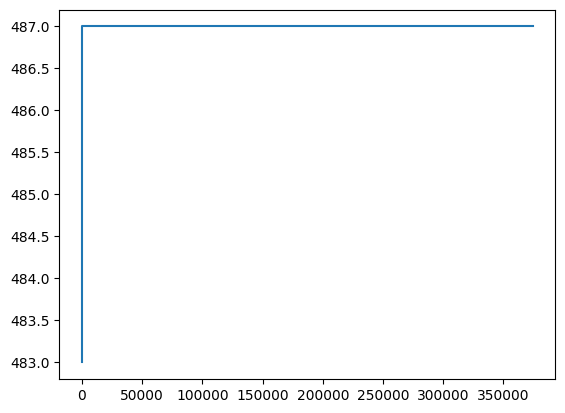

In [16]:
import torch
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
'''
# Global variable to store the result of unit propagation
# unit_prop_result = None
# last_v = None  # To store the last variable assignments
# T_global = None  # To store the clauses


def send_for_unit_propagation(v, mu):
    global last_v, T_global, T
    # Store the last variable assignments and clauses for unit propagation
    last_v = v.clone()
    T_global = T.clone()

def fetch_unit_prop_result():
    global last_v, T_global
    # Perform unit propagation on the last variable assignments
    # and return the new variable assignments
    unit_prop_result = []
    for v_i in last_v:
        v_i_new = v_i.clone()
        changed = True
        while changed:
            changed = False
            # For each clause
            for clause in T_global:
                unassigned_literals = []
                clause_satisfied = False
                for lit in clause:
                    if lit == 0:
                        continue  # Skip padding zeros
                    var_idx = abs(lit) - 1
                    var_value = v_i_new[var_idx].item()
                    if var_value == -1:
                        unassigned_literals.append(lit)
                    elif (lit > 0 and var_value == 1) or (lit < 0 and var_value == 0):
                        clause_satisfied = True
                        break  # Clause is satisfied
                if not clause_satisfied and len(unassigned_literals) == 1:
                    # Unit clause found; assign the unit literal
                    lit = unassigned_literals[0]
                    var_idx = abs(lit) - 1
                    v_i_new[var_idx] = 1 if lit > 0 else 0
                    changed = True  # Changes occurred; need to recheck
        unit_prop_result.append(v_i_new)
    unit_prop_result = torch.stack(unit_prop_result)
    return unit_prop_result
'''

def gather_and_count(v, Q, polarity):
    c = torch.einsum('bv,ckv->bck', v, Q) # (batch_size, num_clause, max_len_clause)
    return c, (((polarity + c) == 2) + ((polarity + c) == -1)).any(dim=-1).sum(dim=-1)

def time_remaining(start_time, time_limit):
    if time.time() - start_time > time_limit:
        return False
    return True

def construct_Q(T, num_var, device):
    Q = torch.zeros(T.shape[0], T.shape[1], num_var, device=device) #(num_clause, len_clause, num_var)
    for clause_idx, clause in enumerate(T):
        for lit_idx, lit in enumerate(clause):
            if lit != 0:
                Q[clause_idx, lit_idx, torch.abs(lit)-1] = 1.0
    return Q

def rbmsat(W_c, b_c, T, B, N, seed, time_limit, upp=100, upw=1, alpha=0.1): # B is batch size, N is the total number of variables
    # Set random seed for reproducibility
    torch.manual_seed(seed)
    
    # Initialize variables
    s_max = 0 # initially 0 clauses are satisfied
    v = torch.bernoulli(torch.ones(B, N, device=W_c.device) * 0.5)  # sample random inits 
    # mu = 0.25 * torch.ones_like(v) 
    # Setup tensors
    polarity = torch.sign(T)  # strictly {1, -1}, not 0 (-1 2 -3) -> (-1 1 -1)
    Q = construct_Q(T, formula.num_vars, device) # C * K * N    (num_clause, max_len_clause, num_var)
    W = torch.einsum('ck,kh->ckh', polarity, W_c) # polarity.unsqueeze(1) * W_c.unsqueeze(2) # element-wise multiplication
    # print(W)
    b = b_c.repeat([T.shape[0], 1]) + torch.mm((1 - polarity) / 2, W_c)
    
    # t, d = 1, -1
    step = 0
    s_max_list = []
    best_v = torch.ones(N, device=W_c.device)
    
    start_time = time.time()
    with torch.no_grad():
        while True:
            if time_remaining(start_time, time_limit):
                step += 1
                # if step == 3:
                #     break
                #     # print(f"step {step}, {s_max_list[-1]}")
                
                # if upp > 0 and d == 0:
                #    v_u = torch.vstack([v, fetch_unit_prop_result()])
                #    _, s_u = gather_and_count(v_u, Q, polarity)
                #    ranks = torch.argsort(s_u)
                #    v = v_u[ranks[-B:]]
                #    mu = torch.vstack([mu, mu])[ranks[-B:]]
                # if upp > 0 and t % upp == 0:
                #     d = upw
                #     send_for_unit_propagation(v, mu)
                    
                c, s = gather_and_count(v, Q, polarity)
                s_max_step, idx_max = s.max(dim=0)
                # print(s_max_step.item())
                # print(f"v:{v[idx_max]}")
                if s_max_step.item() > s_max:
                    s_max = s_max_step.item()
                    best_v = v[idx_max].clone()
                    s_max_list.append((step, s_max))
                    print(f"new s_max found {s_max} at step {step}")

                h_logits = b + torch.einsum('bck,ckh->bch', c, W) # 'bck,chk->bhk'  bck,ckh->bch
                
                h = torch.bernoulli(torch.sigmoid(h_logits))
                # print(h[0,0:10])
                ro = torch.sigmoid(torch.einsum('bch,ckh,ckv->bv', h, W, Q)) # 'bhk,chk,ckv->bv'
                # print(f"ro:{ro}")
                # mu = (1 - alpha) * mu + alpha * ro * (1 - ro)
                v = torch.bernoulli(ro)
                
                # t, d = t + 1, max(d - 1, -1)
            else:
                s_max_list.append((step, s_max_list[-1][-1]))
                break
        
    return s_max_list, best_v

T = torch.tensor(formula.clauses, device=device)

bath_size = 128
seed = 42
timeout = 300

alpha = 0.1
upp = 100
upw = 1

s_max, best_v = rbmsat(rbm.W, rbm.b, T, bath_size, formula.num_vars, seed, timeout, upp, upw, alpha)
print(best_v)
x_ax, y_ax = zip(*s_max)
plt.step(x_ax,y_ax)

In [5]:
v = torch.tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
        1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device=device)

def construct_Q(T, num_var, device):
    Q = torch.zeros(T.shape[0], T.shape[1], num_var, device=device) #(num_clause, len_clause, num_var)
    for clause_idx, clause in enumerate(T):
        for lit_idx, lit in enumerate(clause):
            if lit != 0:
                Q[clause_idx, lit_idx, torch.abs(lit)-1] = 1.0
    return Q

def gather_and_count(v, Q, polarity):
    c = torch.einsum('bv,ckv->bck', v, Q) # (batch_size, num_clause, max_len_clause)
    print(c)
    print(polarity)
    return c, (((polarity + c) == 2) + ((polarity + c) == -1)).any(dim=-1).sum(dim=-1)

T = torch.tensor(formula.clauses, device=device)
polarity = torch.sign(T)  # strictly {1, -1}, not 0 (-1 2 -3) -> (-1 1 -1)
Q = construct_Q(T, formula.num_vars, device) # C * K * N    (num_clause, max_len_clause, num_var)
c, s = gather_and_count(v, Q, polarity)
print(s)

tensor([[[0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]], device='cuda:0')
tensor([[-1,  1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        [-1,  1,  0,  0,  0,  0],
        ...,
        [-1,  0,  0,  0,  0,  0],
        [-1,  0,  0,  0,  0,  0],
        [-1,  0,  0,  0,  0,  0]], device='cuda:0')
tensor([2682], device='cuda:0')


In [ ]:
from utils import unit_propagation, count_satisfied_clauses

v = unit_propagation(formula, s_max[1].cpu())
# current_best_v, current_best_num_satisfied = count_satisfied_clauses(formula, v)
print(v)

tensor([0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
        0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 1., 0.], grad_fn=<IndexPutBackward0>)


assignment test

In [7]:
v[0,79]

tensor(1., device='cuda:0')

In [14]:
import torch
from utils import CNFFormula
from main import count_satisfied_clauses
v = torch.tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
        1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

# v_str = "111111101111111001111111111111010111111111100011011100111011101101110001111111101111011011111111011110011111111111101110110110011110010"

# v = torch.tensor([[int(i) for i in v_str]])

with open("wcnfdata/uaq-min-nr-nr50-np400-rpp5-nc0-rs0-t0-plb100-n9.wcnf", 'r') as f:
    cnf_str = f.read()
formula = CNFFormula(cnf_str)

best_v, best_num_satisfied = count_satisfied_clauses(
    formula, 
    v
)
print(best_num_satisfied)
print(best_v)

2682
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
         0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
         0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
         1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0.

In [12]:
v_str = "1 -2 -3 -4 -5 -6 7 -8 -9 -10 -11 12 -13 -14 -15 -16 17 -18 -19 20 -21 -22 23 -24 -25 -26 27 -28 -29 30 -31 -32 -33 -34 -35 -36 -37 -38 39 -40 -41 42 -43 -44 45 46 -47 48 49 -50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 -155 156 157 -158 159 160 161 162 163 164 165 166 167 -168 169 170 171 172 173 174 175 -176 177 178 179 180 181 182 183 184 185 -186 187 188 189 190 191 192 -193 194 195 196 197 198 199 200 -201 202 -203 204 205 206 -207 208 209 210 211 212 213 -214 215 -216 -217 218 219 220 221 222 223 -224 225 -226 227 228 229 230 231 232 233 234 235 -236 237 238 -239 -240 241 242 243 244 245 246 -247 248 249 250 251 252 253 254 255 256 257 258 259 260 -261 -262 -263 264 265 266 267 268 269 270 271 272 -273 274 275 276 277 278 279 280 281 -282 283 284 285 286 287 288 289 290 -291 292 -293 294 295 296 -297 -298 299 -300 301 302 303 304 305 306 307 -308 -309 310 311 312 -313 -314 -315 316 317 318 319 320 321 322 323 324 325 326 -327 328 329 330 -331 332 333 334 335 336 337 338 339 340 341 342 343 -344 345 346 347 348 349 350 351 352 -353 354 355 356 357 -358 359 -360 361 362 363 364 -365 -366 367 368 369 -370 -371 372 373 374 375 376 -377 -378 -379 380 381 382 383 384 385 386 387 -388 389 390 391 392 393 -394 -395 -396 -397 398 -399 400 401 402 403 404 405 406 407 408 409 410 411 -412 413 -414 415 416 417 418 419 420 -421 422 423 424 -425 426 427 428 429 430 431 -432 -433 434 -435 -436 437 438 439 -440 441 442 443 444 -445 -446 447 -448 -449 -450"
v_list = v_str.split()
v_temp = []
for var in v_list:
    if int(var) > 0:
        v_temp.append(1.0)
    else:
        v_temp.append(0.0)

v_torch = torch.tensor([v_temp])
print(v_torch)


tensor([[1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
         0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
         1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
         0., 1., 1., 1., 1.,

In [10]:
v_item = v[0].tolist()
for idx, var in enumerate(v_item):
    if var == 1.0:
        print(idx+1)

52
53
58
61
66
71
72
75
78
80
82
87
91
100
102
103
108
120
124
127
138
139
141
142
143
145
149
150
163
189
195
214
251
308
327
342
439


In [ ]:
from utils import CNFFormula
from main import solve_maxsat
import os

best_v_list = []
best_num_satisfied_list = []
# test all files in ../wcnfdata
for file in os.listdir("./wcnfdata"):
    print(file)
    with open(os.path.join("./wcnfdata", file), 'r') as f:
        formula_str = f.read()
    
    formula = CNFFormula(formula_str)
    best_v, best_num_satisfied = solve_maxsat(
        formula, 
        max_time=300, 
        heuristic_interval=100, 
        batch_size=1024)

    best_v_list.append(best_v)
    best_num_satisfied_list.append(best_num_satisfied)

    print(f"{file}, {best_num_satisfied}")

brock200_3.clq.wcnf
Step 100, Best: 813, current: 810, formula size: 1038, Elapsed Time: 16.84s
Step 200, Best: 818, current: 803, formula size: 1038, Elapsed Time: 29.70s
Step 300, Best: 818, current: 801, formula size: 1038, Elapsed Time: 44.76s
Step 400, Best: 818, current: 801, formula size: 1038, Elapsed Time: 60.85s
Step 500, Best: 818, current: 806, formula size: 1038, Elapsed Time: 77.98s
Step 600, Best: 818, current: 802, formula size: 1038, Elapsed Time: 97.43s
Step 700, Best: 818, current: 805, formula size: 1038, Elapsed Time: 110.33s
Step 800, Best: 818, current: 802, formula size: 1038, Elapsed Time: 123.68s
Step 900, Best: 818, current: 806, formula size: 1038, Elapsed Time: 136.62s
Step 1000, Best: 818, current: 803, formula size: 1038, Elapsed Time: 149.38s
Step 1100, Best: 818, current: 808, formula size: 1038, Elapsed Time: 162.05s
Step 1200, Best: 818, current: 796, formula size: 1038, Elapsed Time: 174.84s
Step 1300, Best: 818, current: 804, formula size: 1038, Ela

RuntimeError: einsum(): subscript h has size 7 for operand 1 which does not broadcast with previously seen size 8

In [ ]:
import torch
from utils import CNFFormula
from main import count_satisfied_clauses
v = torch.tensor([[0,1,1,0,0,0,0,0,1,1,1,0,1,1,1,0,0,1,0,0,1,1,0,1,1,0,0,1,0,0,1,0,1,1,0,1,1,0,0,1]])

with open('./wcnfdata/brock200_3.clq.wcnf', 'r') as f:
    formula_str = f.read()
formula = CNFFormula(formula_str)
best_v, best_num_satisfied = count_satisfied_clauses(
    formula, 
    v
)
print(best_num_satisfied)

822


In [20]:
from models.rbm import clauseRBM
import torch

rbm_random = clauseRBM(5, F_s=-1.0, num_epochs=0, lr=0.01, device='cpu', verbose=True)
rbm_trained = clauseRBM(5, F_s=-1.0, num_epochs=20000, lr=0.01, device='cpu', verbose=True)

v_neg = torch.tensor([[0.0, 0.0, 0.0, 0.0, 0.0]])
v_pos1 = torch.tensor([[1.0, 0.0, 0.0, 0.0, 0.0]])
v_pos2 = torch.tensor([[1.0, 1.0, 0.0, 0.0, 0.0]])
v_pos3 = torch.tensor([[1.0, 1.0, 1.0, 0.0, 0.0]])
v_pos4 = torch.tensor([[1.0, 1.0, 1.0, 1.0, 0.0]])
v_pos5 = torch.tensor([[1.0, 1.0, 1.0, 1.0, 1.0]])

print(rbm_random.free_energy(v_neg).item(), rbm_random.free_energy(v_pos1).item(), rbm_random.free_energy(v_pos2).item(), rbm_random.free_energy(v_pos3).item(), rbm_random.free_energy(v_pos4).item(), rbm_random.free_energy(v_pos5).item())
print(rbm_trained.free_energy(v_neg).item(), rbm_trained.free_energy(v_pos1).item(), rbm_trained.free_energy(v_pos2).item(), rbm_trained.free_energy(v_pos3).item(), rbm_trained.free_energy(v_pos4).item(), rbm_trained.free_energy(v_pos5).item())

Saved pre-trained RBM to rbm_models\rbm_length_5_F_-1.0_num_epochs_0_lr_0.01_device_cpu.pth
Epoch 200, Loss: 0.40392351150512695
Epoch 400, Loss: 0.15035410225391388
Epoch 600, Loss: 0.07847076654434204
Epoch 800, Loss: 0.054054055362939835
Epoch 1000, Loss: 0.0438944511115551
Epoch 1200, Loss: 0.03873978182673454
Epoch 1400, Loss: 0.03555965796113014
Epoch 1600, Loss: 0.033251821994781494
Epoch 1800, Loss: 0.031401023268699646
Epoch 2000, Loss: 0.0298561193048954
Epoch 2200, Loss: 0.028566580265760422
Epoch 2400, Loss: 0.027515148743987083
Epoch 2600, Loss: 0.026690170168876648
Epoch 2800, Loss: 0.026074139401316643
Epoch 3000, Loss: 0.02563847415149212
Epoch 3200, Loss: 0.025342069566249847
Epoch 3400, Loss: 0.025134537369012833
Epoch 3600, Loss: 0.02496362291276455
Epoch 3800, Loss: 0.024781839922070503
Epoch 4000, Loss: 0.024546733126044273
Epoch 4200, Loss: 0.024215035140514374
Epoch 4400, Loss: 0.02373451739549637
Epoch 4600, Loss: 0.02303897961974144
Epoch 4800, Loss: 0.02205649

In [ ]:
from utils import CNFFormula, count_satisfied_clauses
from models.rbm import formulaRBM
import torch

with open('./wcnfdata/brock200_3.clq.wcnf', 'r') as f:
    formula_str = f.read()
formula = CNFFormula(formula_str)
n_visible = formula.num_vars
v_init = torch.bernoulli(torch.full((1, n_visible), 0.5, device="cuda"))

print(count_satisfied_clauses(formula, v_init.cpu()))

rbm_trained = formulaRBM(formula,
                         num_epochs=10000,
                         device="cuda")

v = v_init.clone()
for _ in range(100):
    h_sample, _ = rbm_trained.sample_h_given_v(v)
    v_sample, p_v_given_h = rbm_trained.sample_v_given_h(h_sample)
    v = v_sample

    # plot the F_s each step

print(f"trained {count_satisfied_clauses(formula, v.cpu())}")
v1 = v.clone()


rbm_random = formulaRBM(formula,
                        num_epochs=0,
                        device="cuda")

v = v_init.clone()
for _ in range(100):
    h_sample, _ = rbm_random.sample_h_given_v(v)
    v_sample, p_v_given_h = rbm_random.sample_v_given_h(h_sample)
    v = v_sample
print(f"random {count_satisfied_clauses(formula, v.cpu())}")

v2 = v.clone()


(tensor([[1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
         1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1.,
         0., 1., 1., 0.]]), 783)
trained (tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1.,
         0., 1., 1., 0.]]), 755)
random (tensor([[0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
         0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1.,
         0., 0., 0., 1.]]), 789)


In [2]:
print(rbm_trained.free_energy(v_init))
print(rbm_trained.free_energy(v1))
print(rbm_trained.free_energy(v2))

tensor([819.0408], device='cuda:0')
tensor([1106.0283], device='cuda:0')
tensor([772.8834], device='cuda:0')


Training consistently leads to worse results

In [ ]:
from utils import CNFFormula
from models.rbm import formulaRBM
import torch

with open('./test02.cnf', 'r') as f:
    formula_str = f.read()
formula = CNFFormula(formula_str)

rbm_trained = formulaRBM(formula,
                         num_epochs=10000,
                         device="cuda")

print(rbm_trained.W_full)

tensor([[ 1.9978, -3.1180,  0.0000,  0.0000, -2.3297,  3.9816, -2.4516,  2.3680,
          1.0588,  2.0557,  1.2671, -4.1289,  2.4115],
        [-1.1680,  6.0914, -1.9978,  3.1180,  5.4193, -1.5878, -1.0259,  4.1523,
         -0.5033, -1.9225, -0.8347, -0.4400, -2.4606],
        [ 0.0000,  0.0000, -1.1680,  6.0914, -1.1188, -1.4281,  5.4664, -0.6311,
         -0.3739,  4.0862, -0.5167, -0.5561, -1.6324],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -1.6017,
          3.5612, -2.3678,  3.1999, -0.8163, -2.3878],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.3785,
         -0.1678, -0.7122, -0.6422, -0.3692,  4.1957]], device='cuda:0')


In [12]:
from models.rbm import clauseRBM

rbm_len2 = clauseRBM(2, F_s=-1.0, num_epochs=10000, lr=0.01, device='cuda')

print(rbm_len2.W)
print(rbm_len2.b)
print(rbm_len2.d)

Parameter containing:
tensor([[ 1.9978, -3.1180],
        [-1.1680,  6.0914]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-5.6222, -5.4554], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.9735, -0.0620], device='cuda:0', requires_grad=True)


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import time
from utils import CNFFormula, count_satisfied_clauses, unit_propagation
class clauseRBM_symmetric(nn.Module):
    def __init__(self, clause_length=2, F_s=-1.0, num_epochs=20000, lr=0.1, verbose=False):
        super(clauseRBM_symmetric, self).__init__()
        self.n_visible = clause_length
        self.n_hidden = clause_length if clause_length <= 3 else clause_length + 1

        # self.train_clause_rbm(F_s=F_s, num_epochs=num_epochs, lr=lr)
        self.W = torch.Tensor([[-3.3325e-08,  1.1686e-08],[-3.3325e-08,  1.1686e-08]])
        self.d = torch.Tensor([0.5 , 0.5])
        self.b = torch.Tensor([-2.0163, -2.0163])
    
    def train_clause_rbm(self, F_s=-1.0, num_epochs=30000, lr=0.1):
        
        self.W = nn.Parameter(torch.randn(1, self.n_hidden) * 0.1)
        self.d = nn.Parameter(torch.zeros(1))
        self.b = nn.Parameter(torch.zeros(1))

        optimizer = optim.Adam(self.parameters(), lr=0.01)

        # Generate all possible binary vectors
        n_samples = 2 ** self.n_visible
        v_vectors = torch.tensor([ [int(x) for x in bin(i)[2:].zfill(self.n_visible)] for i in range(n_samples)], dtype=torch.float32)
        # print(v_vectors)
        # Target free energies
        F_targets = torch.zeros(n_samples)
        for i in range(n_samples):
            if v_vectors[i].sum() == 0:
                F_targets[i] = 0.0
            else:
                F_targets[i] = F_s
        # Training loop
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            F_v = self.free_energy(v_vectors)
            loss = torch.mean((F_v - F_targets) ** 2)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:
                print(f"Epoch {epoch+1}, Loss: {loss.item()}")
        
    
    def free_energy(self, v):
        # v: batch_size x n_visible
        v_term = torch.sum(self.d * v, dim=1)
        # print(v_term)
        # print(self.W)
        W_expanded = self.W.expand(v.shape[1], self.n_hidden)
        # print(W_expanded)
        pre_activation = self.b + torch.matmul(v, W_expanded)
        # print(pre_activation)
        h_term = torch.sum(torch.log1p(torch.exp(pre_activation)), dim=1)
        F_v = -v_term - h_term
        # print(F_v)
        return F_v  # batch_size
    
rbm = clauseRBM_symmetric()
print(rbm.free_energy(torch.tensor([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])))
print(rbm.W)
print(rbm.d)
print(rbm.b)

tensor([-0.2500, -0.7500, -0.7500, -1.2500])
tensor([[-3.3325e-08,  1.1686e-08],
        [-3.3325e-08,  1.1686e-08]])
tensor([0.5000, 0.5000])
tensor([-2.0163, -2.0163])


In [22]:
class formulaRBM_symmetric:
    def __init__(self, 
                 formula: CNFFormula, 
                 device='cpu'):

        literal_clauses = formula.to_literal_form()
        n_visible_total = formula.num_vars
        n_hidden_total = 0
        for clause in literal_clauses:
            clause_length = len(clause)
            n_hidden = clause_length if clause_length <= 3 else clause_length + 1
            n_hidden_total += n_hidden

        self.W_full = torch.zeros(n_visible_total, n_hidden_total, device=device)
        self.b_full = torch.zeros(n_hidden_total, device=device)
        self.d_full = torch.zeros(n_visible_total, device=device)
        
        curr_hidden_idx = 0

        for clause in literal_clauses:
            # clause: list of (var_idx, is_negated)
            variable_indices, signs = zip(*clause)
            # variable_indices = [var_idx for (var_idx, is_negated) in clause]
            # signs = [is_negated for (var_idx, is_negated) in clause]
            
            clause_length = len(clause)
            n_visible = clause_length
            n_hidden = n_visible if n_visible <= 3 else n_visible + 1
            
            # Get pre-trained RBM for this clause length
            rbm = clauseRBM_symmetric(clause_length)
            
            # Adjust W and b according to signs
            Lambda = torch.tensor([-1.0 if is_negated else 1.0 for is_negated in signs], device=device)
            W = rbm.W.detach()  # size n_visible x n_hidden
            b = rbm.b.detach()  # size n_hidden
            d = rbm.d.detach()  # size n_visible
            
            W_prime = Lambda.unsqueeze(1) * W  # size n_visible x n_hidden
            b_prime = b + 0.5 * torch.matmul((1 - Lambda), W)
            
            # Map W_prime into W_full
            for local_var_idx, var_idx in enumerate(variable_indices):
                self.W_full[var_idx, curr_hidden_idx : curr_hidden_idx + n_hidden] += W_prime[local_var_idx, :]
                self.d_full[var_idx] += d[local_var_idx]
            # Map b_prime into b_full
            self.b_full[curr_hidden_idx : curr_hidden_idx + n_hidden] = b_prime
            
            curr_hidden_idx += n_hidden

        self.n_visible = n_visible_total
        self.n_hidden = n_hidden_total
        self.device = device
        
    def sample_h_given_v(self, v):
        # v: batch_size x n_visible
        p_h_given_v = torch.sigmoid(self.b_full + torch.matmul(v, self.W_full))
        h_sample = torch.bernoulli(p_h_given_v)
        return h_sample, p_h_given_v
    
    def sample_v_given_h(self, h):
        # h: batch_size x n_hidden
        p_v_given_h = torch.sigmoid(self.d_full + torch.matmul(h, self.W_full.t()))
        v_sample = torch.bernoulli(p_v_given_h)
        return v_sample, p_v_given_h
    
    def gibbs_sampling(self, v_init, k=1):
        v = v_init
        for _ in range(k):
            h_sample, _ = self.sample_h_given_v(v)
            v_sample, _ = self.sample_v_given_h(h_sample)
            v = v_sample
        return v

    def free_energy(self, v):
        return torch.sum(v * self.d_full, dim=1) + torch.sum(torch.log(1 + torch.exp(self.b_full + torch.matmul(v, self.W_full))), dim=1)

In [ ]:

with open('./wcnfdata/brock200_3.clq.wcnf', 'r') as f:
    formula_str = f.read()
formula = CNFFormula(formula_str)

rbm_trained = formulaRBM_symmetric(formula)
batch_size = 1
heuristic_interval = 100
max_time = 60

n_visible = rbm_trained.n_visible

# Initialize v to random assignment
v = torch.bernoulli(torch.full((batch_size, n_visible), 0.5))

best_v, best_num_satisfied = count_satisfied_clauses(formula, v.cpu())

start_time = time.time()

# Unit propagation heuristic: Initialize moving averages of ν_i
nu_i = torch.zeros(n_visible)
alpha = 0.9  # Decay factor for moving average
step = 0
while True:
    step += 1
    
    # Sample h given v
    h_sample, _ = rbm_trained.sample_h_given_v(v)
    # Sample v given h
    v_sample, p_v_given_h = rbm_trained.sample_v_given_h(h_sample)
    v = v_sample
    
    # Update moving averages of ν_i
    rho_i = p_v_given_h.mean(dim=0)  # size n_visible
    nu_i = alpha * nu_i + (1 - alpha) * (rho_i * (1 - rho_i))
    
    # Every heuristic_interval steps, apply heuristic
    if step % heuristic_interval == 0:
        # Rank variables by ν_i
        _, indices = torch.sort(nu_i)
        num_vars_to_unassign = n_visible // 2
        vars_to_unassign = indices[:num_vars_to_unassign]
        # Set these variables to unassigned (-1)

        assignments = []
        for i in range(batch_size):
            assignment = v[i].clone()
            assignment[vars_to_unassign] = -1  # Unassign variables
            # Apply unit propagation
            assignment = unit_propagation(formula, assignment.cpu())
            assignments.append(assignment)
        v = torch.stack(assignments, dim=0)  # Shape: (B, N)
        # Reset moving averages
        nu_i.zero_()
    
    # Evaluate current assignment
    current_best_v, current_best_num_satisfied = count_satisfied_clauses(formula, v)
    if current_best_num_satisfied > best_num_satisfied:
        best_num_satisfied = current_best_num_satisfied
        best_v = current_best_v.clone()
    
    if best_num_satisfied == formula.num_clauses:
        print(f"Solved in {step} steps")
        break
    
    # Optional: print progress
    if step % 100 == 0:
        elapsed_time = time.time() - start_time
        print(f"Step {step}, Best: {best_num_satisfied}, current: {current_best_num_satisfied}, formula size: {formula.num_clauses}, Elapsed Time: {elapsed_time:.2f}s")
    
    # Check time limit
    if time.time() - start_time >= max_time:
        print(f"Time limit reached: {max_time} seconds")
        break

Step 100, Best: 787, current: 787, formula size: 1038, Elapsed Time: 3.95s
Step 200, Best: 787, current: 787, formula size: 1038, Elapsed Time: 7.69s
Step 300, Best: 787, current: 787, formula size: 1038, Elapsed Time: 11.50s
Step 400, Best: 787, current: 787, formula size: 1038, Elapsed Time: 15.21s
Step 500, Best: 787, current: 787, formula size: 1038, Elapsed Time: 18.94s
Step 600, Best: 787, current: 787, formula size: 1038, Elapsed Time: 22.76s
Step 700, Best: 787, current: 787, formula size: 1038, Elapsed Time: 26.37s
Step 800, Best: 787, current: 787, formula size: 1038, Elapsed Time: 29.79s
Step 900, Best: 787, current: 787, formula size: 1038, Elapsed Time: 33.35s
Step 1000, Best: 787, current: 787, formula size: 1038, Elapsed Time: 37.06s
Step 1100, Best: 787, current: 787, formula size: 1038, Elapsed Time: 40.70s
Step 1200, Best: 787, current: 787, formula size: 1038, Elapsed Time: 44.51s
Step 1300, Best: 787, current: 787, formula size: 1038, Elapsed Time: 48.07s
Step 1400,

In [20]:
a = torch.ones(5)
a

tensor([1., 1., 1., 1., 1.])

In [ ]:
from utils import CNFFormula
from models.rbm import clauseRBM
import torch
import time
import matplotlib.pyplot as plt


with open("wcnfdata/brock200_3.clq.wcnf", 'r') as f:
    cnf_str = f.read()

formula = CNFFormula(cnf_str)
formula.padding()
rbm = clauseRBM(formula.max_clause_length)

def gather_and_count(v, Q, polarity):
    c = torch.einsum('bv,ckv->bck', v, Q) # (batch_size, num_clause, max_len_clause)
    return c, (((polarity + c) == 2) + ((polarity + c) == -1)).any(dim=-1).sum(dim=-1)

def time_remaining(start_time, time_limit):
    if time.time() - start_time > time_limit:
        return False
    return True

def construct_Q(T, num_var):
    Q = torch.zeros(T.shape[0], T.shape[1], num_var) #(num_clause, len_clause, num_var)
    for clause_idx, clause in enumerate(T):
        for lit_idx, lit in enumerate(clause):
            if lit != 0:
                Q[clause_idx, lit_idx, torch.abs(lit)-1] = 1.0
    return Q

def rbmsat(W_c, b_c, T, B, N, seed, time_limit, upp=100, upw=1, alpha=0.1): # B is batch size, N is the total number of variables
    # Set random seed for reproducibility
    torch.manual_seed(seed)
    
    # Initialize variables
    s_max = 0 # initially 0 clauses are satisfied
    v = torch.bernoulli(torch.ones(B, N, device=W_c.device) * 0.5)  # sample random inits 

    # Setup tensors
    polarity = torch.sign(T)  # strictly {1, -1}, not 0 (-1 2 -3) -> (-1 1 -1)
    Q = construct_Q(T, formula.num_vars) # C * K * N    (num_clause, max_len_clause, num_var)
    W = torch.einsum('ck,kh->ckh', polarity, W_c) # polarity.unsqueeze(1) * W_c.unsqueeze(2) # element-wise multiplication
    b = b_c.repeat([T.shape[0], 1]) + torch.mm((1 - polarity) / 2, W_c)
    
    # t, d = 1, -1
    step = 0
    s_max_list = []
    best_v = torch.ones(N, device=W_c.device)
    
    start_time = time.time()
    while time_remaining(start_time, time_limit):
        step += 1
            
        c, s = gather_and_count(v, Q, polarity)
        s_max_step, idx_max = s.max(dim=0)
        if s_max_step.item() > s_max:
            s_max = s_max_step.item()
            best_v = v[idx_max].clone()
            s_max_list.append((step, s_max))
            print(f"new s_max found {s_max} at step {step}")

        h_logits = b + torch.einsum('bck,ckh->bch', c, W) # 'bck,chk->bhk'  bck,ckh->bch
        h = torch.bernoulli(torch.sigmoid(h_logits))
        ro = torch.sigmoid(torch.einsum('bch,ckh,ckv->bv', h, W, Q)) # 'bhk,chk,ckv->bv'
        v = torch.bernoulli(ro)
        
    return s_max_list, best_v

T = torch.tensor(formula.clauses)

alpha = 0.1
upp = 100
upw = 1

s_max, best_v = rbmsat(rbm.W, rbm.b, T, 128, formula.num_vars, 42, 300, upp, upw, alpha)
print(best_v)
x_ax, y_ax = zip(*s_max)
plt.step(x_ax,y_ax)
plt.show()